In [1]:
! pip install nibabel
! pip install nilearn
! pip install -q nilearn

import nibabel as nib
import pandas as pd
import os
import numpy as np

In [2]:
run='1'

behav_data_path = f'/Users/graceliu/Desktop/ColumbiaThesis/data/trial_by_trial_WSW.csv'
behav_df = pd.read_csv(behav_data_path)
behav_df.head()

,subj_id,statement,face,selected_face,rt,correct,cat_chosen,cat_correct,within_error,between_error
0,1,The more he talked - the more it became eviden...,CFD-WM-020-001-N.jpg,CFD-BM-032-024-N.jpg,NaN,0,B,W,0,1
1,1,I don't know. He did seem a bit worked up. I w...,CFD-BM-004-002-N.jpg,CFD-WM-238-020-N.jpg,NaN,0,W,B,0,1
2,1,I tried hard not to engage too much - but he k...,CFD-BM-043-071-N.jpg,CFD-WM-238-020-N.jpg,NaN,0,W,B,0,1
3,1,I wanted to just walk away. It wasn't worth wa...,CFD-WM-225-127-N.jpg,CFD-WM-225-127-N.jpg,NaN,1,W,W,0,0
4,1,Yeah they were supposed to be there. Their car...,CFD-WM-225-127-N.jpg,CFD-BM-043-071-N.jpg,NaN,0,B,W,0,1


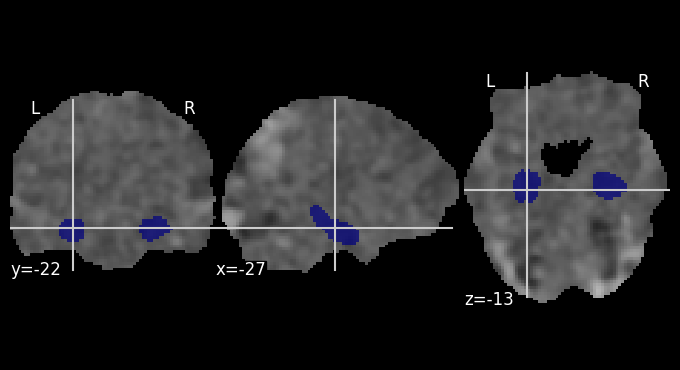

In [3]:
from nilearn.image import resample_to_img
from nilearn.plotting import plot_roi, show

#subject 001 zmap (reference image)
run1 = "/Users/graceliu/Desktop/ColumbiaThesis/zmaps/sub-001_encoding_correct_within_bt2_between_error_zmap.nii.gz"
img = nib.load(run1)

#hippocampus mask (source image)
hipp_file_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_association-test_z_FDR_0.01.nii.gz"
hipp_img = nib.load(hipp_file_path)

#resample hippocampus mask to match Z-map
resampled_hipp_mask = resample_to_img(hipp_img, img, interpolation='continuous')

#convert resampled mask to numpy array
resampled_mask_data = resampled_hipp_mask.get_fdata()

#apply threshold to only focus on hippocampus ROI
binary_mask = (resampled_mask_data > 12).astype(np.uint8)

#save resampled mask as a new NIfTI file
mask_img = nib.Nifti1Image(binary_mask, resampled_hipp_mask.affine, resampled_hipp_mask.header)

hipp_save_path = "/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_resampled.nii.gz"
nib.save(mask_img, hipp_save_path)

plot_roi(mask_img, bg_img = img)
show()

# Individual face neural patterns during category localizer for a two group split: untrustworthy and trustworthy

### classify faces as trustworthy or untrustworthy based on each subject's own distribution of seen faces --> use their own median trustworthiness ratings as a cutoff
- controls for which specific faces each subject saw
- better for analyzing within-subject differences (e.g. did subject 1 respond differently to faces they perceived as more vs. less trustworthy)
- hard to interpet globally since not all subjects have the same definition/threshold for trustworthy/untrustworthy


output: average neural activation for trust/untrust faces PER SUBJECT

In [4]:
all_TD_ratings_path = '/Users/graceliu/Desktop/ColumbiaThesis/data/T_D_ratings_WSW.csv'
all_TD_ratings = pd.read_csv(all_TD_ratings_path)
all_TD_ratings.head()

,Model,Trustworthy Rating,Dominant Rating
0,BM-001,3.063830,3.230769
1,BM-002,3.617021,3.703704
2,BM-003,2.813187,4.200000
3,BM-004,3.178295,2.695312
4,BM-005,3.315217,2.846154


# Trust vs. untrust
## All faces

In [5]:
map_root = "/Users/graceliu/Desktop/ColumbiaThesis/individual_ID_maps"
hipp_mask_img = nib.load("/Users/graceliu/Desktop/ColumbiaThesis/brain_masks/hippocampus_resampled.nii.gz")
hipp_data = hipp_mask_img.get_fdata().astype(bool)

trustworthy_vals, untrustworthy_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Trustworthy Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on subject-specific median
            if trust_rating > sub_median:
                trustworthy_vals.append(mean_hipp)
            else:
                untrustworthy_vals.append(mean_hipp)

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals):.4f} (n={len(trustworthy_vals)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals):.4f} (n={len(untrustworthy_vals)})")

Trustworthy mean: 0.0326 (n=1860)
Untrustworthy mean: 0.0292 (n=1860)


In [6]:
from scipy.stats import ttest_ind

t_stat_hipp, p_val_hipp = ttest_ind(trustworthy_vals, untrustworthy_vals, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

t = 1.0020
p = 0.3164


## BM only

In [7]:
trustworthy_vals, untrustworthy_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "BM-" in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Trustworthy Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "BM-" in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on subject-specific median
            if trust_rating > sub_median:
                trustworthy_vals.append(mean_hipp)
            else:
                untrustworthy_vals.append(mean_hipp)

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals):.4f} (n={len(trustworthy_vals)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals):.4f} (n={len(untrustworthy_vals)})")

Trustworthy mean: 0.0335 (n=930)
Untrustworthy mean: 0.0291 (n=930)


In [8]:
from scipy.stats import ttest_ind

t_stat_hipp, p_val_hipp = ttest_ind(trustworthy_vals, untrustworthy_vals, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

t = 0.9106
p = 0.3626


## WM only

In [9]:
trustworthy_vals, untrustworthy_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "WM-" in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Trustworthy Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "WM-" in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            trust_rating = row["Trustworthy Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on subject-specific median
            if trust_rating > sub_median:
                trustworthy_vals.append(mean_hipp)
            else:
                untrustworthy_vals.append(mean_hipp)

# Final average results
print(f"Trustworthy mean: {np.mean(trustworthy_vals):.4f} (n={len(trustworthy_vals)})")
print(f"Untrustworthy mean: {np.mean(untrustworthy_vals):.4f} (n={len(untrustworthy_vals)})")

Trustworthy mean: 0.0315 (n=930)
Untrustworthy mean: 0.0294 (n=930)


In [10]:
t_stat_hipp, p_val_hipp = ttest_ind(trustworthy_vals, untrustworthy_vals, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

t = 0.4534
p = 0.6503


# Dom vs. nondom
## All faces

In [19]:
dominant_vals, nondominant_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Dominant Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz"):
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            dom_rating = row["Dominant Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on subject-specific median
            if dom_rating > sub_median:
                dominant_vals.append(mean_hipp)
            else:
                nondominant_vals.append(mean_hipp)

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Nondominant mean: {np.mean(nondominant_vals):.4f} (n={len(nondominant_vals)})")

Dominant mean: 0.0320 (n=1860)
Nondominant mean: 0.0297 (n=1860)


In [20]:
t_stat_hipp, p_val_hipp = ttest_ind(dominant_vals, nondominant_vals, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

t = 0.6691
p = 0.5035


## BM only

In [21]:
dominant_vals, nondominant_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "BM-" in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Dominant Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "BM-" in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            dom_rating = row["Dominant Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on subject-specific median
            if dom_rating > sub_median:
                dominant_vals.append(mean_hipp)
            else:
                nondominant_vals.append(mean_hipp)

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Nondominant mean: {np.mean(nondominant_vals):.4f} (n={len(nondominant_vals)})")

Dominant mean: 0.0294 (n=930)
Nondominant mean: 0.0332 (n=930)


In [22]:
t_stat_hipp, p_val_hipp = ttest_ind(dominant_vals, nondominant_vals, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

t = -0.7820
p = 0.4343


## WM only

In [23]:
dominant_vals, nondominant_vals = [], []
for sub in range(1, 33):
    sub_id = f"sub-{sub:03d}"
    if sub_id == "sub-011":
        continue

    #check if subject folder exists before continuing    
    sub_folder = os.path.join(map_root, sub_id)
    if not os.path.isdir(sub_folder):
        print(sub_folder, 'FOLDER DOES NOT EXIST')

    face_ids_seen = []

    # First pass: collect all face IDs this subject has seen (from file names)
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "WM-" in f:
            face_id = f.split("_")[1]  # assumes format like sub-001_BM-001_run-1.nii.gz
            face_ids_seen.append(face_id)

    # check if there are duplicates
    assert len(face_ids_seen) == len(set(face_ids_seen)), f"ERROR: there are duplicates!"

    # Get trust ratings for only the faces this subject saw
    sub_ratings = all_TD_ratings[all_TD_ratings["Model"].isin(face_ids_seen)]  

    sub_median = sub_ratings["Dominant Rating"].median()

    # Second pass: process each face file
    for f in os.listdir(sub_folder):
        if f.endswith(".nii.gz") and "WM-" in f:
            face_id = f.split("_")[1]

            # Get the trust rating for this face
            row = all_TD_ratings[all_TD_ratings["Model"] == face_id]
            if row.empty:
                print("Error")
                print(row)
            dom_rating = row["Dominant Rating"].values[0]

            # Load neural data
            map_path = os.path.join(sub_folder, f)
            img = nib.load(map_path)
            data = img.get_fdata()
            mean_hipp = np.nanmean(data[hipp_data])

            # Classify based on subject-specific median
            if dom_rating > sub_median:
                dominant_vals.append(mean_hipp)
            else:
                nondominant_vals.append(mean_hipp)

# Final average results
print(f"Dominant mean: {np.mean(dominant_vals):.4f} (n={len(dominant_vals)})")
print(f"Nondominant mean: {np.mean(nondominant_vals):.4f} (n={len(nondominant_vals)})")

Dominant mean: 0.0329 (n=930)
Nondominant mean: 0.0280 (n=930)


In [25]:
t_stat_hipp, p_val_hipp = ttest_ind(dominant_vals, nondominant_vals, equal_var=False)
print(f"t = {t_stat_hipp:.4f}")
print(f"p = {p_val_hipp:.4f}")

t = 1.0133
p = 0.3111
